# PubMed Abstracts Modeling: Regression Model
### *Citations as Target*

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#nlp
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re

#modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [69]:
filename = '../data/pubmed_cleaned_no_outliers.csv'

In [70]:
df = pd.read_csv(filename).drop(columns = 'Unnamed: 0')

In [71]:
df.set_index(['pmid'],inplace=True)

In [72]:
df.columns

Index(['title', 'text', 'date', 'citations', 'len_text', 'len_title',
       'days_live'],
      dtype='object')

### Simple MLR Model with Numerical Variables: Citations as Target

In [73]:
X = df[['len_text','len_title','days_live']]
y = df['citations']

In [74]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 random_state=42)

In [75]:
results = sm.OLS(y_train, X_train).fit()

In [76]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              citations   R-squared (uncentered):                   0.396
Model:                            OLS   Adj. R-squared (uncentered):              0.395
Method:                 Least Squares   F-statistic:                              490.9
Date:                Mon, 10 May 2021   Prob (F-statistic):                   3.33e-245
Time:                        10:22:52   Log-Likelihood:                         -8929.0
No. Observations:                2247   AIC:                                  1.786e+04
Df Residuals:                    2244   BIC:                                  1.788e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
len_text       0.0014      0.001      2.749      0.006       0.000       0.002
len_title     -0.0118      0.008     -1.482      0.138      -0.027       0.004
days_live      0.0091      0.000     23.712      0.000       0.008       0.010
==============================================================================
Omnibus:                     1561.457   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22884.639
Skew:                           3.164   Prob(JB):                         0.00
Kurtosis:                      17.296   Cond. No.                         48.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Both the length of the abstract and the number of days that an article has been live have a stastistically significant effect on the number of citations, but in both cases, the effect is extremely small. The small set of numerical features accounts for a very small percentage of the variance in citations. I wll move on to NLP.

### NLP

In [84]:
#read in pre-processed data
df = pd.read_csv('../data/pubmed_nltk_stemmed_preproc.csv').set_index('pmid')

#### Look at Word Frequency in the Corpus

In [51]:
X = df['fulltext']
y = df['citations']

In [52]:
cvec = CountVectorizer(ngram_range=(1,2), max_features=10_000)


In [53]:
# convert training data to dataframe
X_cvec = pd.DataFrame(cvec.fit_transform(X).todense(),
                         columns=cvec.get_feature_names())

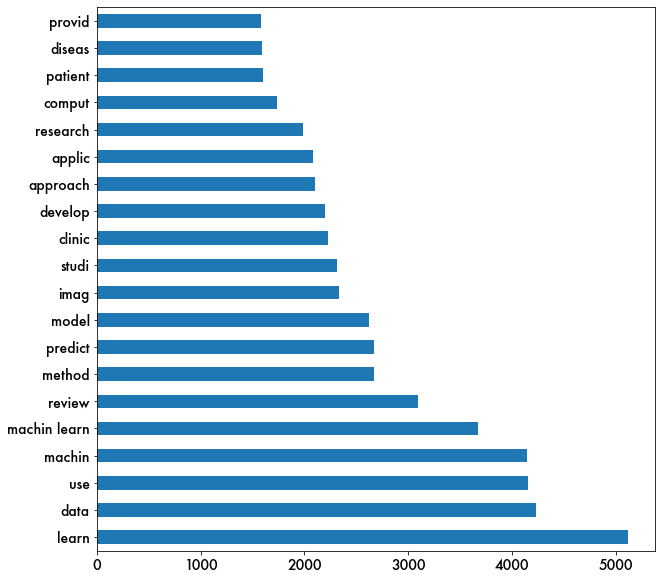

In [54]:
# plot top occurring words/phrases
plt.figure(figsize = (10,10))
X_cvec.sum().sort_values(ascending = False).head(20).plot(kind='barh');
figurefont = {'fontname' : 'Futura'}
plt.xticks(**figurefont, fontsize = 14);
plt.yticks(**figurefont, fontsize = 14);
#plt.savefig('figures/top_occurring_stemmed.jpg',  bbox_inches = "tight")

In [55]:
tvec = TfidfVectorizer(ngram_range=(1,2), max_features=10_000)


In [56]:
# convert training data to dataframe
X_tvec = pd.DataFrame(tvec.fit_transform(X).todense(),
                         columns=tvec.get_feature_names())

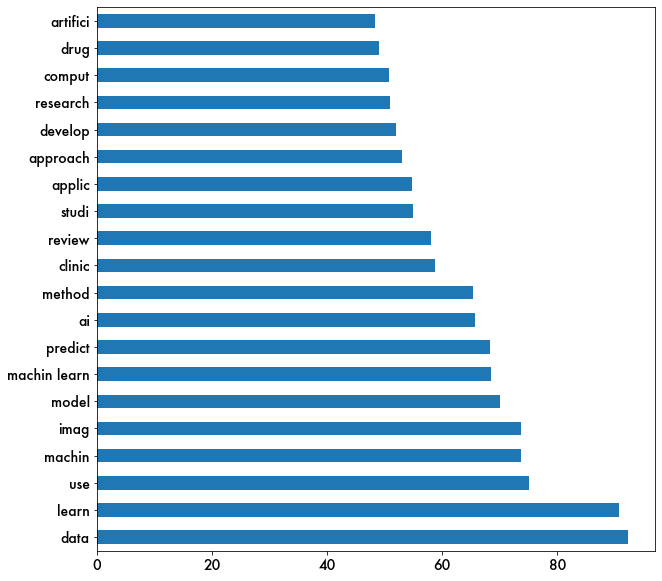

In [57]:
# plot top occurring words/phrases
plt.figure(figsize = (10,10))
X_tvec.sum().sort_values(ascending = False).head(20).plot(kind='barh');
figurefont = {'fontname' : 'Futura'}
plt.xticks(**figurefont, fontsize = 14);
plt.yticks(**figurefont, fontsize = 14);
#plt.savefig('figures/top_occurring_stemmed.jpg',  bbox_inches = "tight")

In [58]:
#train-test split
X_train, X_test, y_train, y_test=train_test_split(X,
                                                 y,
                                                 test_size=.2,
                                                 random_state=42)

#### Count Vectorizer

In [59]:
cvec = CountVectorizer(min_df=5, max_df=.98, ngram_range=(1,2))

In [60]:
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [61]:
model_list = [
    LinearRegression(),
    DecisionTreeRegressor(),
    BaggingRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
]

results_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj
   
    #fit the model
    model.fit(X_train_cvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_cvec, y_train)
    results_dict['test_score'] = model.score(X_test_cvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_cvec, y_train, cv = 5).mean()
    results_dict['train_RMSE'] = np.sqrt(mean_squared_error(y_train, model.predict(X_train_cvec)))
    results_dict['test_RMSE'] = np.sqrt(mean_squared_error(y_test, model.predict(X_test_cvec))) 
    
    #add the dictionary to the list
    results_list.append(results_dict)

In [62]:
results = pd.DataFrame(results_list)
results

,model_name,train_score,test_score,cv_score,train_RMSE,test_RMSE
0,LinearRegression(),1.000000,-0.788389,-0.591634,0.000022,19.044473
1,DecisionTreeRegressor(),1.000000,-0.618626,-0.943003,0.000000,18.118039
2,BaggingRegressor(),0.815854,-0.182414,-0.192903,6.074498,15.485409
3,RandomForestRegressor(),0.856277,-0.088209,-0.097244,5.366516,14.855733
4,AdaBoostRegressor(),-1.202073,-1.187388,-2.226864,21.006103,21.062063


#### TfidfVectorizer

In [63]:
tvec = TfidfVectorizer(min_df=5, max_df=.98, ngram_range=(1,2))

In [64]:
X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [65]:
model_list = [
    LinearRegression(),
    DecisionTreeRegressor(),
    BaggingRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    SVR()
]

results_list = []

for model_obj in model_list:
    #instantiate each model 
    model = model_obj
   
    #fit the model
    model.fit(X_train_tvec, y_train) 
  
    #create a dictionary with scores and evaluation metrics for each model
    results_dict = {}    
    results_dict['model_name'] = str(model_obj)
    results_dict['train_score'] = model.score(X_train_tvec, y_train)
    results_dict['test_score'] = model.score(X_test_tvec, y_test)
    results_dict['cv_score'] = cross_val_score(model, X_train_tvec, y_train, cv = 5).mean()
    results_dict['train_RMSE'] = np.sqrt(mean_squared_error(y_train, model.predict(X_train_tvec)))
    results_dict['test_RMSE'] = np.sqrt(mean_squared_error(y_test, model.predict(X_test_tvec))) 
    
    #add the dictionary to the list
    results_list.append(results_dict)

In [66]:
results = pd.DataFrame(results_list)
results

,model_name,train_score,test_score,cv_score,train_RMSE,test_RMSE
0,LinearRegression(),1.000000,-0.440166,-0.279784,0.000005,17.090089
1,DecisionTreeRegressor(),1.000000,-0.913495,-1.086075,0.000000,19.699342
2,BaggingRegressor(),0.804294,-0.141640,-0.140683,6.262273,15.216075
3,RandomForestRegressor(),0.851397,-0.076951,-0.023216,5.456872,14.778693
4,AdaBoostRegressor(),-2.212335,-2.183204,-1.933502,25.371144,25.407987
5,SVR(),-0.057124,-0.141823,-0.118579,14.554342,15.217292
